In [ ]:
import tensorflow as tf
import os
import re
import shutil
import pandas as pd
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
url='https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
data=tf.keras.utils.get_file('stack_overflow_16k',url,untar=True, cache_dir='.',
                                    cache_subdir='')

6053168/6053168 [==============================] - 0s 0us/step


In [ ]:
data

'./stack_overflow_16k'

In [ ]:
data_dir=os.path.dirname(data)

In [ ]:
os.listdir(os.path.dirname(data))

['.config',
 'test',
 'train',
 'README.md',
 'stack_overflow_16k.tar.gz',
 'sample_data']

In [ ]:
train_data=os.path.join(data_dir,'train')
os.listdir(train_data)

['python', 'java', 'csharp', 'javascript']

In [ ]:
test_data=os.path.join(data_dir,'test')
os.listdir(train_data)

['python', 'java', 'csharp', 'javascript']

In [ ]:
test_python=os.path.join(test_data,'python')
for i in os.listdir(test_python)[:10]:
  with open(os.path.join(test_python,f'{i}')) as f:
    print(f.read()) 

"creating variable number of variables in blank i am trying to create a variable number of variables (arrays) in blank. ..i have a database from experiments and i am extracting data from it. i do not have control over the database or how data is written. i am extracting data in the form of a table - first (or zeroth column from blank's perspective) has location ids and subsequent columns have readings over several iterations. location ids (in 0th col) span over million of rows, and so the readings of the iterations are captured in subsequent columns. so i read over the database and create this giant table.  ..in the next step, i loop over columns index 1 to n (0th col has locations) and i am trying to get this - if the difference in 2 readings is more than 0.001, then write the location id to an array... if ( (a[i][j+1] - a[i][j]) &gt; 0.001): #1&lt;=j&lt;=n, 0&lt;=i&lt;=max rows in the table.   then write a[i][0] i.e. location id to an array, arr1[m][n] = a[i][0]...problem: it is crea

## using the text_dataset_from_directory utility to create a labeled

In [ ]:
train_batch=tf.keras.utils.text_dataset_from_directory('train',seed=42, validation_split=0.2, subset='training')
val_batch=tf.keras.utils.text_dataset_from_directory('train',seed=42, validation_split=0.2, subset='validation')
test_batch=tf.keras.utils.text_dataset_from_directory('test',seed=42)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [ ]:
for text_batch, label_batch in train_batch.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

## Prepare the dataset for training

In [ ]:
def standadization(input_data):
  lower_data=tf.strings.lower(input_data)
  replace_data=tf.strings.regex_replace(lower_data,'<br />','')
  return tf.strings.regex_replace(replace_data,'[%s]'% re.escape(string.punctuation),'')

In [ ]:
vectorize_layer=tf.keras.layers.TextVectorization(max_tokens=1000,standardize=standadization,output_sequence_length=250)

In [ ]:
# Make a text-only dataset  (without labels), then call adapt
train_text = train_batch.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text,label):
  text=tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [ ]:
train_map=train_batch.map(vectorize_text)
val_map=val_batch.map(vectorize_text)
test_map=test_batch.map(vectorize_text)

## Configure the dataset for performance

In [ ]:
autotune=tf.data.AUTOTUNE
train=train_map.cache().prefetch(buffer_size=autotune)
val=val_map.cache().prefetch(buffer_size=autotune)
test=test_map.cache().prefetch(buffer_size=autotune)

In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(1000,16))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 16)          16000     
                                                                 
 dropout_8 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 16,068
Trainable params: 16,068
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer='adam',metrics=['accuracy'],loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
history=model.fit(train,validation_data=val,epochs=50,callbacks=tf.keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True),verbose=2)

Epoch 1/50
200/200 - 3s - loss: 1.3788 - accuracy: 0.3239 - val_loss: 1.3681 - val_accuracy: 0.4212 - 3s/epoch - 14ms/step
Epoch 2/50
200/200 - 1s - loss: 1.3538 - accuracy: 0.4292 - val_loss: 1.3325 - val_accuracy: 0.4888 - 773ms/epoch - 4ms/step
Epoch 3/50
200/200 - 1s - loss: 1.3093 - accuracy: 0.4825 - val_loss: 1.2779 - val_accuracy: 0.5275 - 755ms/epoch - 4ms/step
Epoch 4/50
200/200 - 1s - loss: 1.2506 - accuracy: 0.5141 - val_loss: 1.2144 - val_accuracy: 0.5544 - 792ms/epoch - 4ms/step
Epoch 5/50
200/200 - 1s - loss: 1.1895 - accuracy: 0.5536 - val_loss: 1.1514 - val_accuracy: 0.5975 - 916ms/epoch - 5ms/step
Epoch 6/50
200/200 - 1s - loss: 1.1306 - accuracy: 0.5927 - val_loss: 1.0926 - val_accuracy: 0.6438 - 828ms/epoch - 4ms/step
Epoch 7/50
200/200 - 1s - loss: 1.0751 - accuracy: 0.6272 - val_loss: 1.0396 - val_accuracy: 0.6681 - 785ms/epoch - 4ms/step
Epoch 8/50
200/200 - 1s - loss: 1.0273 - accuracy: 0.6406 - val_loss: 0.9915 - val_accuracy: 0.6787 - 792ms/epoch - 4ms/step
Ep

In [ ]:
model.evaluate(test)

250/250 [==============================] - 1s 4ms/step - loss: 0.6149 - accuracy: 0.7560


[0.6149387955665588, 0.7559999823570251]

In [ ]:
for a,b in train_batch.take(1):
=  print(vectorize_text(a[0],b[0]))

(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 55,   6,   2, 410, 211, 229, 121, 895,   4, 124,  32, 245,  43,
          5,   1,   1,   5,   1,   1,   6,   2, 410, 211, 191, 318,  14,
          2,  98,  71, 188,   8,   2, 199,  71, 178,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
  

In [ ]:
history=history.history

In [ ]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
loss=history['loss']
accuracy=history['accuracy']
val_loss=history['val_loss']
val_accuracy=history['val_accuracy']

Text(0.5, 1.0, 'loss and validation loss')

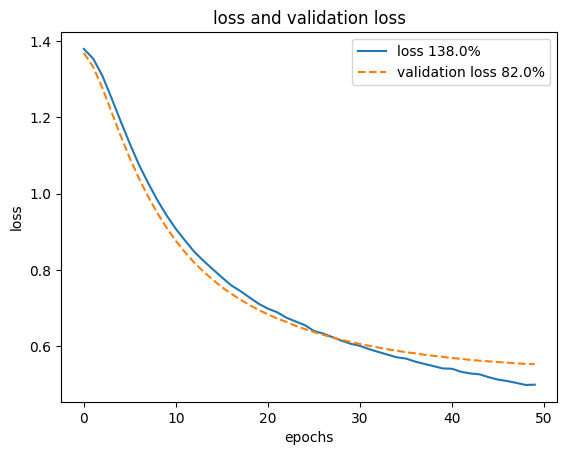

In [ ]:
epochs=50
plt.plot(range(epochs),loss,label=f'loss {round(np.max(loss),2)*100}%')
plt.plot(range(epochs),val_loss,'--',label=f'validation loss {round(np.max(accuracy),2)*100}%')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('loss and validation loss')

Text(0.5, 1.0, 'Accuracy and validation Accuracy')

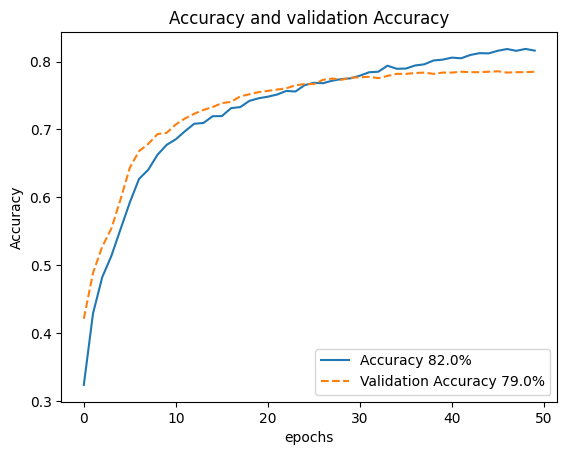

In [ ]:
plt.plot(range(len(loss)),accuracy,label=f'Accuracy {round(np.max(accuracy),2)*100}%')
plt.plot(range(len(loss)),val_accuracy,'--',label=f'Validation Accuracy {round(np.max(val_accuracy),2)*100}%')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy and validation Accuracy')

In [ ]:
export_model =tf.keras.Sequential([vectorize_layer,model,tf.keras.layers.Activation('softmax')])

In [ ]:
export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 126ms/step


array([[0.3290705 , 0.20813507, 0.3268602 , 0.13593425],
       [0.3290705 , 0.20813507, 0.3268602 , 0.13593425],
       [0.3290705 , 0.20813507, 0.32686022, 0.13593425]], dtype=float32)

In [ ]:
test_python=(os.path.join(test_data,'python'))

In [ ]:
exe=[]
asa=os.path.join(test_python,'703.txt')
with open(asa) as f:
  exe.append(f.read())

In [ ]:
exe

['"how to change the color channels of an image in blank? this is a question that probably should be floating around somewhere here, but i don\'t seem to find it...i have this code:..import matplotlib.image as img     ..img1 = img.imread(\'./images_32x32/test_1.png\').print(""shape = "", img1.shape) # output: 32x32x3..img2 = img.imread(\'./images_32x32/test_2.png\').print(""shape = "", img2.shape) # output: 32x32x4...my problem is in the shape of img2 (img2.shape) i would like it to be also 3...how do i change this?"\n']

In [ ]:
export_model.predict(exe)

1/1 [==============================] - 0s 35ms/step


array([[0.09181364, 0.17843649, 0.17666477, 0.5530851 ]], dtype=float32)